# Sao Paulo apartment rent price prediction

In this notebook (still in production), I use the public dataset from Google BigQuery of real state in Brazil.

On Google Cloud I use a query (SQL) to extract only the apartment rent in Sao Paulo. The query was like:

"

SELECT *

FROM `properati-data-public.properties_br.properties_rent_201501`

WHERE place_name = 'São Paulo' and property_type='apartment' and operation='rent'

#GROUP BY property_type

ORDER BY price_per_m2

LIMIT 1000

"

Then I've downloaded the data and treated it here.

## Some data exploration

In [1]:
#Importing some useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Reading the data
df = pd.read_csv('sp1.csv')

In [9]:
#Looking at its columns
df.columns

Index(['id', 'created_on', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat_lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

In [16]:
#How a random item looks like
df.iloc[67,:]

id                                     7546c7a10f711dd7fc173e45115dea0be65ac371
created_on                                                           2014-07-18
operation                                                                  rent
property_type                                                         apartment
place_name                                                            São Paulo
place_with_parent_names                            |Brasil|São Paulo|São Paulo|
country_name                                                             Brasil
state_name                                                            São Paulo
geonames_id                                                                 NaN
lat_lon                                                                     NaN
lat                                                                         NaN
lon                                                                         NaN
price                                   

In [156]:
#Selecting thevariables and the target (price)
pr=df[df[['price', 'rooms','lat','lon']].notnull().all(1)]
pr.shape

(70, 27)

## Some plots

Let's make some plots with the data so we get some intuition and also see nice graphs interpolations.

In [134]:
x=pr[['rooms']].values
y=pr[['price']].values

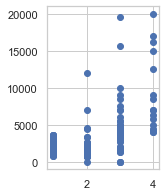

In [135]:
plt.scatter(x,y);

In [123]:
import seaborn as sns

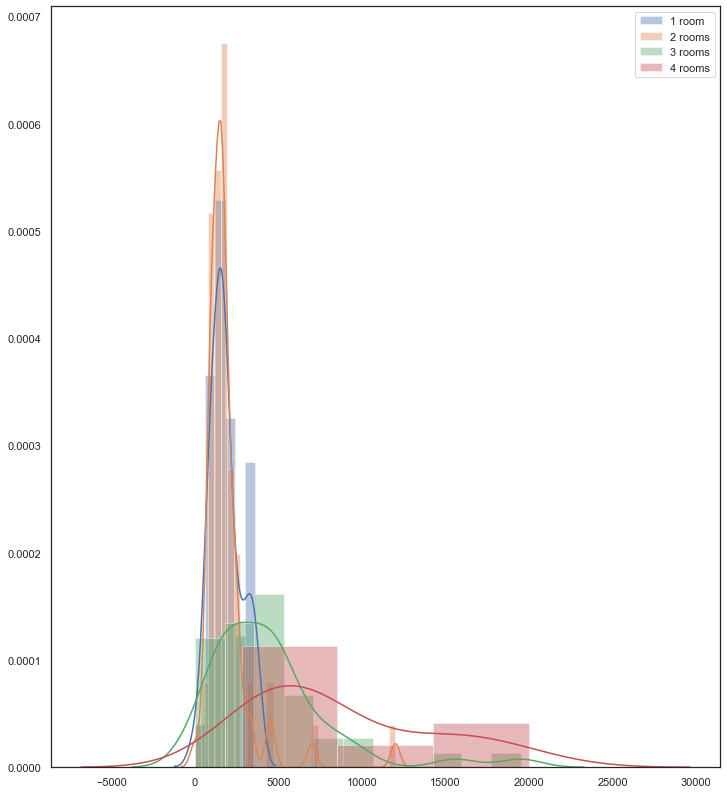

In [54]:
#Plotting the distribution of rooms and their prices with histograms
sns.distplot(a=y[x==1], label='1 room', kde=True)
sns.distplot(a=y[x==2], label='2 rooms', kde=True)
sns.distplot(a=y[x==3], label='3 rooms', kde=True)
sns.distplot(a=y[x==4], label='4 rooms', kde=True)
plt.legend();

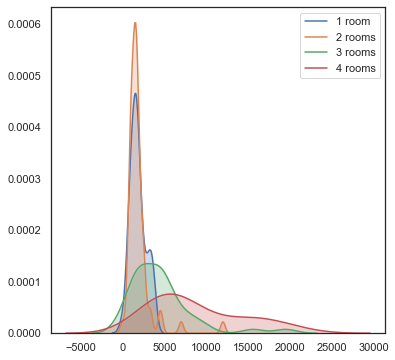

In [51]:
#Plotting only the distributions of rooms and their prices
plt.figure(figsize=(6, 6))
sns.kdeplot(data=y[x==1], label='1 room', shade=True)
sns.kdeplot(data=y[x==2], label='2 rooms', shade=True)
sns.kdeplot(data=y[x==3], label='3 rooms', shade=True)
sns.kdeplot(data=y[x==4], label='4 rooms', shade=True)
sns.set_style("white");

#### Let's see how some regressors act upon it, Random Forest first

In [136]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators = 100, random_state = 0)
reg.fit(x,y.ravel())

RandomForestRegressor(random_state=0)

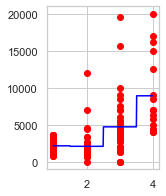

In [137]:
x_grid = np.arange(min(x),max(x),0.01)
x_grid = x_grid.reshape((len(x_grid),1))
plt.scatter(x, y, color= 'red')
plt.plot(x_grid, reg.predict(x_grid), color = 'blue')
sns.set(rc={'figure.figsize':(2,3)})
sns.set_style("whitegrid")
plt.show()

In [84]:
#A predicted price for a supposed 6-room apartment would be:
reg.predict([[6]])

array([3635.25759042])

#### Now, the Support Vector Regressor

In [138]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
x = sc_x.fit_transform(x)
y = sc_y.fit_transform(y)

In [141]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(x,y.ravel());

In [142]:
y_pred = sc_y.inverse_transform(regressor.predict(sc_x.transform(np.array([[6]]))))

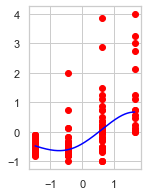

In [143]:
x_grid = np.arange(min(x),max(x),0.01)
x_grid = x_grid.reshape((len(x_grid),1))
plt.scatter(x, y, color= 'red')
plt.plot(x_grid, regressor.predict(x_grid), color = 'blue')
sns.set(rc={'figure.figsize':(2,3)})
sns.set_style("whitegrid")
plt.show()

## Some regressions

This time, I'll focus more on optimizing the regressions to their optimal value, and also will add the Latitude and Longitude (location)

In [157]:
#The variables to be used
x=pr[['rooms','lat', 'lon']].values
y=pr[['price']].values

### Random Forest

In [158]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=23)
rf = RandomForestRegressor(random_state = 23)
param_grid = { 
    'n_estimators': [200, 350, 500],
    'max_depth' : [3,4,5,6],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'criterion' : ['mse','mae']
}
cv_rf=GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2')
cv_rf.fit(x_train,y_train.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=23),
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [3, 4, 5, 6],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 350, 500]},
             scoring='r2')

In [159]:
cv_rf.best_params_

{'criterion': 'mae',
 'max_depth': 3,
 'max_features': 'sqrt',
 'n_estimators': 350}

In [171]:
rf2=RandomForestRegressor(n_estimators=350, max_depth=3, max_features='sqrt', criterion='mae', random_state = 23)
rf2.fit(x_train,y_train.ravel())

predrf2=rf2.predict(x_test)
r2_score(y_test,predrf2)

0.4738354133564082

### ElasticNet

In [172]:
from sklearn.linear_model import ElasticNet

e_n = ElasticNet(random_state=0)
e_n.fit(x_train,y_train)

ElasticNet(random_state=0)

In [173]:
preden=e_n.predict(x_test)
r2_score(y_test,preden)

-1.2581126065767267

### Gradient Regressor

In [174]:
from sklearn.ensemble import GradientBoostingRegressor

gb=GradientBoostingRegressor()
gb.fit(x_train,y_train.ravel())

predgb=gb.predict(x_test)
r2_score(y_test,predgb)

0.4412896221871043

In [98]:
param_grid = { 
    'n_estimators': [50, 100, 300],
    'max_depth' : [3,4,5,6],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'criterion' : ['friedman_mse', 'mse', 'mae']
}
cv_gb=GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='r2')
cv_gb.fit(x_train,y_train.ravel())

C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb

C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb

C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb

C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb

C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb

C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb

C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\ensemble\_gb

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'criterion': ['friedman_mse', 'mse', 'mae'],
                         'max_depth': [3, 4, 5, 6],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 300]},
             scoring='r2')

In [99]:
cv_gb.best_params_

{'criterion': 'mae',
 'max_depth': 3,
 'max_features': 'log2',
 'n_estimators': 50}

In [175]:
gb2=GradientBoostingRegressor(n_estimators=50, max_depth=3, max_features='log2', loss='lad', random_state = 23)
gb2.fit(x_train,y_train.ravel())

predgb2=gb2.predict(x_test)
r2_score(y_test,predgb2)

0.663201445425863